## Prerequisites

You need to install the following libraries to run codes in this article.

1. GridDB C Client
2. GridDB Python client

To install these libraries, follow the installation instructions on [GridDB Python Package Index (Pypi).](https://pypi.org/project/griddb-python/)

The code is executed in [Google Colab](https://colab.research.google.com/), so you do not need to install other libraries.

Run the following script to import the required libraries into your Python application.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import griddb_python as griddb

ModuleNotFoundError: No module named 'griddb_python'

## Inserting Stress Detection Dataset into GridDB

### Downloading and Importing the Stress Detection Dataset From Kaggle

In [ ]:
# Dataset download link
# https://www.kaggle.com/datasets/swadeshi/stress-detection-dataset?resource=download

dataset = pd.read_csv("stress_detection.csv")
print(f"The dataset consists of {dataset.shape[0]} rows and {dataset.shape[1]} columns")
dataset.head()

The dataset consists of 3000 rows and 20 columns


,participant_id,day,PSS_score,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism,sleep_time,wake_time,sleep_duration,PSQI_score,call_duration,num_calls,num_sms,screen_on_time,skin_conductance,accelerometer,mobility_radius,mobility_distance
0,1,1,34,2.322732,4.332193,1.185878,1.570213,3.782094,7.726792,5.190660,6.572069,1,3.924527,12,32,10.703714,3.115730,0.161717,1.145179,2.196851
1,1,2,37,1.761436,3.254120,3.907281,4.072512,1.997145,7.312674,6.170717,8.030168,4,58.318004,3,41,11.012939,0.959144,0.985587,1.021133,0.737825
2,1,3,30,3.025887,1.855002,2.045900,2.317493,3.619225,6.992060,5.318825,7.102420,1,4.941043,4,48,4.877372,3.311629,1.877445,0.478179,0.911673
3,1,4,16,1.948370,4.966676,3.345225,1.607756,3.583524,8.886914,8.061075,8.123294,3,0.295373,11,38,3.462956,0.625721,0.494921,0.630549,3.911418
4,1,5,32,3.343484,2.065936,3.137843,2.118061,2.567347,7.811705,7.312145,7.785143,3,22.300571,17,17,4.861046,0.622609,1.342600,0.254090,1.605132


In [ ]:
dataset["PSS_score"].describe()

count    3000.000000
mean       24.701000
std         8.615781
min        10.000000
25%        17.000000
50%        25.000000
75%        32.000000
max        39.000000
Name: PSS_score, dtype: float64

### Connect to GridDB

In [ ]:
# GridDB connection details
DB_HOST = "127.0.0.1:10001"
DB_CLUSTER = "myCluster"
DB_USER = "admin"
DB_PASS = "admin"

# creating a connection

factory = griddb.StoreFactory.get_instance()

try:
    gridstore = factory.get_store(
        notification_member = DB_HOST,
        cluster_name = DB_CLUSTER,
        username = DB_USER,
        password = DB_PASS
    )

    container1 = gridstore.get_container("container1")
    if container1 == None:
        print("Container does not exist")
    print("Successfully connected to GridDB")

except griddb.GSException as e:
    for i in range(e.get_error_stack_size()):
        print("[", i, "]")
        print(e.get_error_code(i))
        print(e.get_location(i))
        print(e.get_message(i))

Container does not exist
Successfully connected to GridDB


### Create Container for User Stress Data in GridDB

In [ ]:
# drop container if already exists
gridstore.drop_container("user_stress_data")

# Clean column names to remove spaces or forbidden characters in the GridDB container
dataset.columns = [col.strip().replace(" ", "_") for col in dataset.columns]


# Mapping from pandas data types to GridDB data types
type_mapping = {
    'float64': griddb.Type.DOUBLE,
    'int64': griddb.Type.INTEGER,
    'object': griddb.Type.STRING,
    'category': griddb.Type.STRING  # Map category to STRING for GridDB
}


# Generate column_info dynamically
column_info = [[col, type_mapping[str(dtype)]] for col, dtype in dataset.dtypes.items()]

# Define the container info
container_name = "user_stress_data"
container_info = griddb.ContainerInfo(
    container_name, column_info, griddb.ContainerType.COLLECTION, row_key=True
)

# Connecting to GridDB and creating the container
try:
    gridstore.put_container(container_info)
    container = gridstore.get_container(container_name)
    if container is None:
        print(f"Failed to create container: {container_name}")
    else:
        print(f"Successfully created container: {container_name}")

except griddb.GSException as e:
    print(f"Error creating container {container_name}:")
    for i in range(e.get_error_stack_size()):
        print(f"[{i}] Error code: {e.get_error_code(i)}, Message: {e.get_message(i)}")

Successfully created container: user_stress_data


### Insert User Stress Data into GridDB

In [ ]:
try:
    for _, row in dataset.iterrows():
        # Prepare each row's data in the exact order as defined in `column_info`
        row_data = [
            int(row[col]) if dtype == griddb.Type.INTEGER else
            float(row[col]) if dtype == griddb.Type.DOUBLE else
            str(row[col])
            for col, dtype in column_info
        ]
        # Insert the row data into the container
        container.put(row_data)

    print(f"Successfully inserted {len(dataset)} rows of data into {container_name}")

except griddb.GSException as e:
    print(f"Error inserting data into container {container_name}:")
    for i in range(e.get_error_stack_size()):
        print(f"[{i}] Error code: {e.get_error_code(i)}, Message: {e.get_message(i)}")

Successfully inserted 3000 rows of data into user_stress_data


## Stress Detection Using Machine Learning

### Retrieving Data From GridDB

In [ ]:
def retrieve_data_from_griddb(container_name):

    try:
        data_container = gridstore.get_container(container_name)

        # Query all data from the container
        query = data_container.query("select *")
        rs = query.fetch()

        data = rs.fetch_rows()
        return data

    except griddb.GSException as e:
        print(f"Error retrieving data from GridDB: {e.get_message()}")
        return None


stress_dataset = retrieve_data_from_griddb("user_stress_data")
stress_dataset.head()

,participant_id,day,PSS_score,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism,sleep_time,wake_time,sleep_duration,PSQI_score,call_duration,num_calls,num_sms,screen_on_time,skin_conductance,accelerometer,mobility_radius,mobility_distance
0,1,30,31,4.648641,3.153995,1.464671,2.178070,3.187147,5.695631,8.330830,6.986301,1,0.244167,18,24,6.786352,4.840468,0.611260,0.428267,4.298461
1,2,30,17,1.834975,2.174029,3.739041,4.941045,3.864220,5.638858,5.215126,7.369205,3,51.017245,18,34,3.174265,1.710636,1.959500,0.952418,2.421902
2,3,30,33,3.067008,2.439111,4.836771,4.019720,4.419844,5.449934,7.421669,8.038234,1,22.881146,8,36,10.679299,4.622110,0.116874,0.349740,4.505333
3,4,30,25,4.052216,2.260151,2.492690,3.728662,2.751463,8.123747,6.657600,6.476620,4,26.575908,9,12,11.552337,4.670945,1.011511,0.704466,4.563165
4,5,30,32,3.703551,4.477285,4.199028,2.187114,2.102987,6.575536,6.346036,7.806904,3,54.385229,7,43,8.260210,2.896228,1.555102,1.068751,4.922352


### Predicting User Stress with Machine Learning

In [ ]:
X = stress_dataset.drop(columns=['PSS_score'])
y = stress_dataset['PSS_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:

rf_model = RandomForestRegressor(random_state=42, n_estimators=1000)
rf_model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=1000, random_state=42)

In [ ]:
rf_predictions = rf_model.predict(X_test)

# Evaluate the regression model
mae = mean_absolute_error(y_test, rf_predictions)

print(f"Mean Absolute Error: {mae:.4f}")


Mean Absolute Error: 7.8973


### Predicting User Stress with Deep Learning

In [ ]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1)
])

# Adaptive learning rate scheduler with exponential decay
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9
)

# Compile the model with Adam optimizer and a regression loss
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Summary of the model
model.summary()

/home/mani/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-23 18:00:31.424286: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,825 (54.00 KB)

 Trainable params: 13,377 (52.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:

# Define callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model with the callbacks
history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=4,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 753.5713 - mean_absolute_error: 25.8859 - val_loss: 707.0306 - val_mean_absolute_error: 25.5270
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 697.3970 - mean_absolute_error: 24.8423 - val_loss: 699.9147 - val_mean_absolute_error: 25.3798
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 688.7100 - mean_absolute_error: 24.6571 - val_loss: 692.2277 - val_mean_absolute_error: 25.2246
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 536.3854 - mean_absolute_error: 21.7276 - val_loss: 685.2131 - val_mean_absolute_error: 25.0808
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 633.3154 - mean_absolute_error: 23.6699 - val_loss: 678.1906 - val_mean_absolute_error: 24.9413
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 614.7640 - mean_absolute_error: 23.4141 - val_loss: 667.4274 - val_mean_absolute_error: 24.7224
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 577.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mean Absolute Error: 7.8981


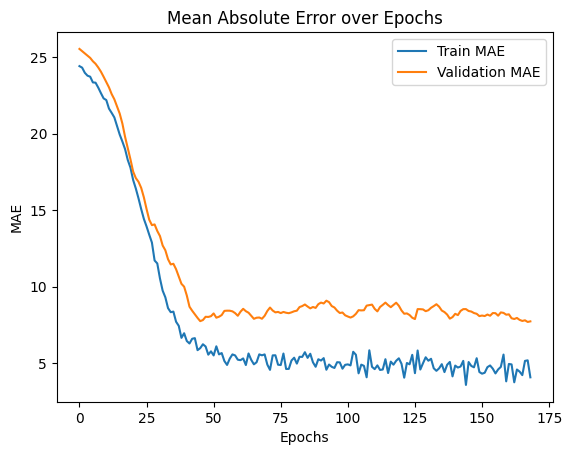

In [ ]:

# Load the best model
best_model = load_model('best_model.keras')

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

# Plot training history to show MAE over epochs
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()